In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
data = pd.read_csv("./data/Question4.csv")

In [47]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [49]:
nan_counts = data.isna().sum()
nan_counts

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [50]:
correlation_matrix = data.select_dtypes(exclude=["object"]).corr()

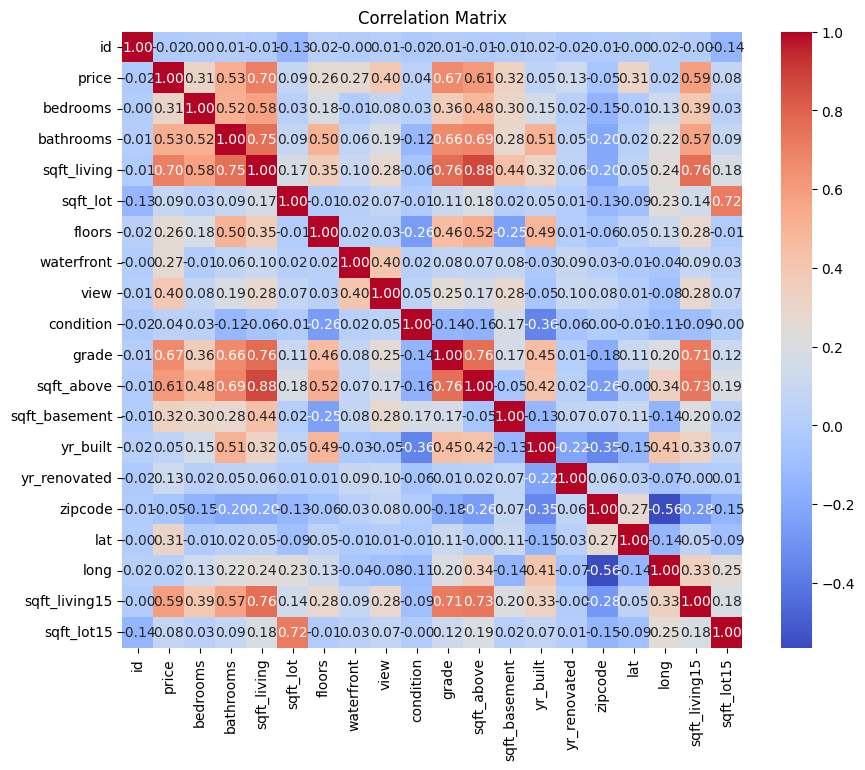

In [51]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [52]:
price_correlations = correlation_matrix["price"].sort_values(ascending=False)
print("The top features with the most correlation with Price:")
print(price_correlations[1:4])

The top features with the most correlation with Price:
sqft_living    0.702035
grade          0.667434
sqft_above     0.605567
Name: price, dtype: float64


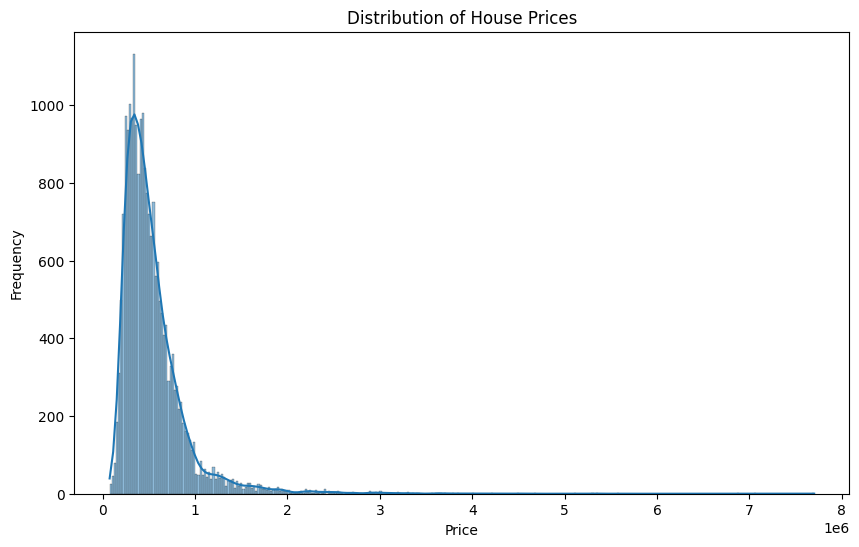

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

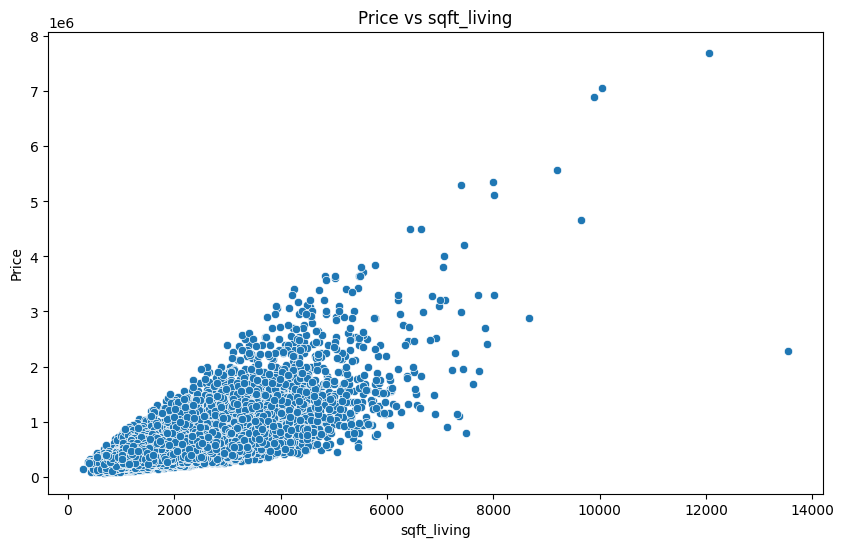

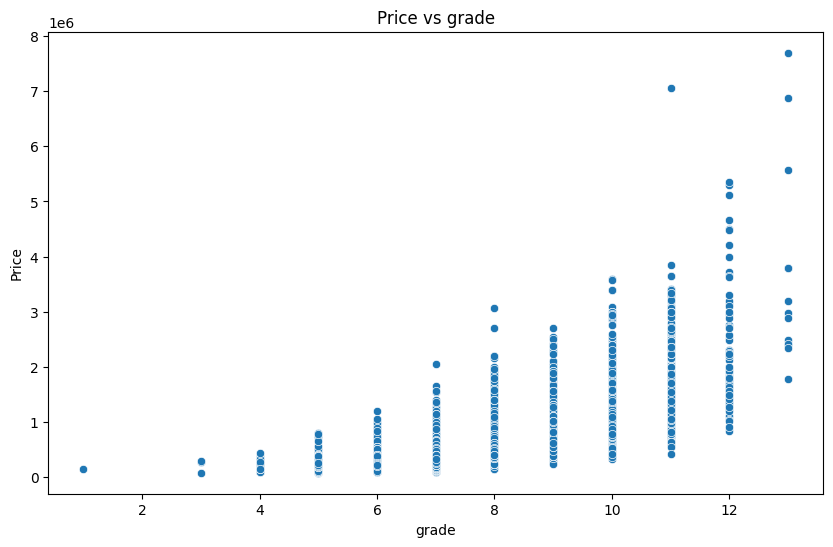

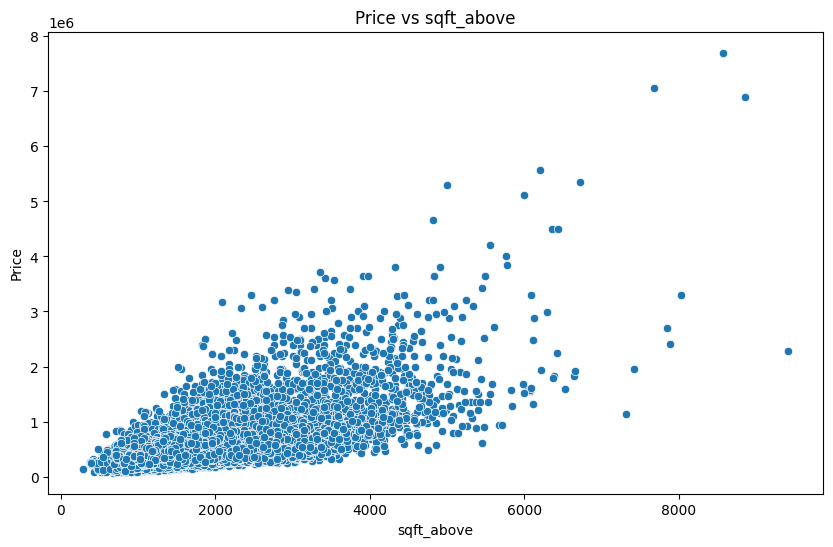

In [54]:
for i in range(1,4):
    top_feature = price_correlations.index[i] 
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=data[top_feature], y=data['price'])
    plt.title(f"Price vs {top_feature}")
    plt.xlabel(top_feature)
    plt.ylabel("Price")
    plt.show()

In [55]:
data['date'] = pd.to_datetime(data['date'], errors='coerce', format='%Y%m%dT%H%M%S')

data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

data = data.drop(columns=['date'])
data

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,...,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,360000.0,3,2.50,1530,1131,3.0,0,0,3,...,0,2009,0,98103,47.6993,-122.346,1530,1509,2014,5
21609,6600060120,400000.0,4,2.50,2310,5813,2.0,0,0,3,...,0,2014,0,98146,47.5107,-122.362,1830,7200,2015,2
21610,1523300141,402101.0,2,0.75,1020,1350,2.0,0,0,3,...,0,2009,0,98144,47.5944,-122.299,1020,2007,2014,6
21611,291310100,400000.0,3,2.50,1600,2388,2.0,0,0,3,...,0,2004,0,98027,47.5345,-122.069,1410,1287,2015,1
